# Mirror circuit benchmarks
This notebook shows how to generate and analyze experiments that are similar to those performed in "Measuring the Capabilities of Quantum Computers" arXiv:2008.11294. For more details, see arXiv:2008.11294

In [1]:
import pygsti
from pygsti.processors import QubitProcessorSpec, CliffordCompilationRules
from pygsti.protocols import MirrorRBDesign as RMCDesign
from pygsti.protocols import PeriodicMirrorCircuitDesign as PMCDesign
from pygsti.protocols import ByDepthSummaryStatistics as SummaryStats
import numpy as np

In [2]:
n_qubits = 4
qubit_labels = ['Q'+str(i) for i in range(n_qubits)] 
gate_names = ['Gcnot'] + ['Gc{}'.format(i) for i in range(24)] 
availability = {'Gcnot':[('Q'+str(i),'Q'+str((i+1) % n_qubits)) for i in range(n_qubits)]}
pspec = QubitProcessorSpec(n_qubits, gate_names, availability=availability, qubit_labels=qubit_labels)

In [3]:
clifford_compilations = {'absolute': pygsti.processors.CliffordCompilationRules.create_standard(pspec, verbosity=0)}

In [4]:
# This cell is utility code for deciding how long the longest circuits should be. You
# may want to choose this by hand instead.

# A guess at the rough per-qubit error rate for picking the maximum depth
# to go to at each width. Change as appropriate. Putting this too low will
# just mean you run longer and more circuits than necessary.
estimated_qubit_error_rate = 0.005

# Heuristic for removing depths that are so long that you'll get no
# useful data for w-qubit circuits. You could do this another way.
def trim_depths(depths, w):
    target_polarization = 0.01 
    maxdepth = np.log(target_polarization)/(w * np.log(1 - estimated_qubit_error_rate))
    trimmed_depths = [d for d in depths if d < maxdepth]
    numdepths = len(trimmed_depths)
    if numdepths < len(depths) and trimmed_depths[-1] < maxdepth:
        trimmed_depths.append(depths[numdepths])
    return trimmed_depths

In [5]:
# This cell sets the circuit sampling parameters. These parameters are chosen
# so as to replicate the experiments shown in Figs. 2 and 3 of arXiv:2008.11294.

# The number of circuits per circuit shape (width and depth). Set this to 40
# to replicate the experiments in arXiv:2008.11294. A smaller number might
# be a good idea for a fast test run.
circuits_per_shape = 10

# The circuit widths to include in the benchmark.
widths = [i for i in range(1, n_qubits + 1)]

# The circuit depths to include, as a function of width.
base_depths = [0,] +  [int(d) for d in 2**np.arange(1, 15)]
depths = {w:trim_depths(base_depths,w) for w in widths}

# The one-or-more qubit subsets to test for each width. You might want
# to choose them more intelligently than here (in arXiv:2008.11294 we used the
# qubits that were "best" according to their RB calibration data, although
# there's nothing special about that strategy).
qubit_lists = {w:[tuple([q for q in qubit_labels[:w]])] for w in widths}

for w in widths:
    print(w, depths[w], qubit_lists[w])
    
# Sets the two-qubit gate density in the circuits (where "density" refers
# to the number of circuit locations occupied by a CNOT, with each CNOT
# occupying two locations).
xi = 1/8

1 [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] [('Q0',)]
2 [0, 2, 4, 8, 16, 32, 64, 128, 256, 512] [('Q0', 'Q1')]
3 [0, 2, 4, 8, 16, 32, 64, 128, 256, 512] [('Q0', 'Q1', 'Q2')]
4 [0, 2, 4, 8, 16, 32, 64, 128, 256] [('Q0', 'Q1', 'Q2', 'Q3')]


In [6]:
# Samples randomized mirror circuits, using the `edgegrab` sampler with the two-qubit gate
# density specified above. The `edgegrab` sampler is what is used in the experiments of
# Figs. 2 and 3 in arXiv:2008.11294 (and not what was used for the experiments of Fig. 1d).
edesigns = {}
for w in widths:
    for qs in qubit_lists[w]:
        print(w, qs)
        key = str(w) + '-' + '-'.join(qs) + '-' + 'RMCs'
        edesigns[key] = RMCDesign(pspec, depths[w], circuits_per_shape, 
                                  clifford_compilations=clifford_compilations,
                                  qubit_labels=qs, sampler='edgegrab', 
                                  samplerargs=[2 * xi,])

1 ('Q0',)
- Sampling 10 circuits at MRB length 0 (1 of 11 depths) with seed 287329
- Sampling 10 circuits at MRB length 2 (2 of 11 depths) with seed 287339
- Sampling 10 circuits at MRB length 4 (3 of 11 depths) with seed 287349
- Sampling 10 circuits at MRB length 8 (4 of 11 depths) with seed 287359
- Sampling 10 circuits at MRB length 16 (5 of 11 depths) with seed 287369
- Sampling 10 circuits at MRB length 32 (6 of 11 depths) with seed 287379
- Sampling 10 circuits at MRB length 64 (7 of 11 depths) with seed 287389
- Sampling 10 circuits at MRB length 128 (8 of 11 depths) with seed 287399
- Sampling 10 circuits at MRB length 256 (9 of 11 depths) with seed 287409
- Sampling 10 circuits at MRB length 512 (10 of 11 depths) with seed 287419
- Sampling 10 circuits at MRB length 1024 (11 of 11 depths) with seed 287429
2 ('Q0', 'Q1')
- Sampling 10 circuits at MRB length 0 (1 of 10 depths) with seed 857746
- Sampling 10 circuits at MRB length 2 (2 of 10 depths) with seed 857756
- Sampling 1

In [7]:
# Samples periodic mirror circuits using the random germ selection algorithm specified
# in arXiv:2008.11294, designed to match the RMCs sampled above (except that they're
# periodic, not disordered).
for w in widths:
    for qs in qubit_lists[w]:
        print(w, qs)
        key = str(w) + '-' + '-'.join(qs) + '-' + 'PMCs'
        edesigns[key] = PMCDesign(pspec, depths[w], circuits_per_shape,
                                  clifford_compilations=clifford_compilations, 
                                  qubit_labels=qs, sampler='edgegrab', 
                                  samplerargs=[xi,])

1 ('Q0',)
2 ('Q0', 'Q1')
3 ('Q0', 'Q1', 'Q2')
4 ('Q0', 'Q1', 'Q2', 'Q3')


In [8]:
edesign = pygsti.protocols.CombinedExperimentDesign(edesigns)

pygsti.io.write_empty_protocol_data('../tutorial_files/test_mirror_benchmark', edesign, clobber_ok=True)

# All the circuits that need to be run
circuits = edesign.all_circuits_needing_data

# Shuffle the circuits: best to run them in a random order.
np.random.shuffle(circuits)

# Write this circuit list to file (the non-random order list is in the edesign folder).
pygsti.io.write_circuit_list('../tutorial_files/test_mirror_benchmark/randomized_circuits.txt', circuits)

# Convert to a list of OpenQASM format circuits. You may or may not want to use this 
# to get the pyGSTi circuits into a format that you can run on your device.
qasm = [c.convert_to_openqasm(standard_gates_version='x-sx-rz') for c in circuits]

# You'd then run the circuits of `qasm` or `circuits` and put them into a pyGSTi dataset
# that replaces the empty dataset `test_mirror_benchmark/data/dataset.txt`. Below we instead
# create simulated data.

In [9]:
# Creates simulated data.
lindblad_error_coeffs = {g:{('H','Z'):0.01, ('S','X'):0.001} for g in gate_names if g != 'Gcnot'}
lindblad_error_coeffs['Gcnot'] = {('H','XX'):0.05, ('S','XI'):0.005}
noisemodel = pygsti.models.create_crosstalk_free_model(pspec, lindblad_error_coeffs=lindblad_error_coeffs)
ds = pygsti.io.fill_in_empty_dataset_with_fake_data('../tutorial_files/test_mirror_benchmark/data/dataset.txt', noisemodel, num_samples=1000, seed=1234)

In [10]:
# Loads the data
data = pygsti.io.read_data_from_dir('../tutorial_files/test_mirror_benchmark')

In [11]:
# The statistics to compute for each circuit.
statistics = ['polarization', 'success_probabilities', 'success_counts', 'total_counts', 'two_q_gate_count']
stats_generator = pygsti.protocols.SimpleRunner(SummaryStats(statistics_to_compute=statistics))

# Computes the stats
summary_data = stats_generator.run(data)

# Turns this "summary" data into a DataFrame
df = summary_data.to_dataframe('ValueName', drop_columns=['ProtocolName','ProtocolType'])

# Adds a row that tells us which type of circuit the row is for. Will not work if the `keys` in the
# edesign are changed to not include `RMCs` or `PMCs`. 
df['CircuitType'] = ['RMC' if 'RMCs' in p[0] else 'PMC' for p in df['Path']]

# Redefines "depth" as twice what is in the Depth column, because the circuit generation code currently
# uses a different convention to that used in arXiv:2008.11294.
df['Depth'] = 2*df['Depth']

# Puts the DataFrame into VBDataFrame object that can be used to create VB plots
vbdf = pygsti.protocols.VBDataFrame(df)

C:\Users\ciostro\Documents\pyGSTi_random_bugfixes\pygsti\protocols\vbdataframe.py:109: RuntimeWarning: divide by zero encountered in log
  llr += -2 * (total_counts - s) * (_np.log(1 - threshold) - _np.log(1 - p))
C:\Users\ciostro\Documents\pyGSTi_random_bugfixes\pygsti\protocols\vbdataframe.py:109: RuntimeWarning: invalid value encountered in scalar multiply
  llr += -2 * (total_counts - s) * (_np.log(1 - threshold) - _np.log(1 - p))
C:\Users\ciostro\Documents\pyGSTi_random_bugfixes\pygsti\report\vbplot.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter([indd], [indw], marker="s", s=280 * scale - 30 * linewidth, c=point_color,


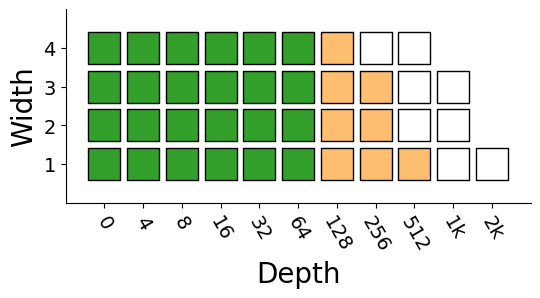

In [12]:
# Creates a capability region plot like those in Fig. 3 of arXiv:2008.11294.
fig, ax = pygsti.report.capability_region_plot(vbdf, figsize=(6, 8), scale=2)

In [13]:
# Extracts the data for a plot like Fig. 2a of arXiv:2008.11294.
vb_min = {}
for circuit_type in ('RMC', 'PMC'):   
    vbdf1 = vbdf.select_column_value('CircuitType', circuit_type)
    vb_min[circuit_type] = vbdf1.vb_data(metric='polarization', statistic='monotonic_min', no_data_action='min')

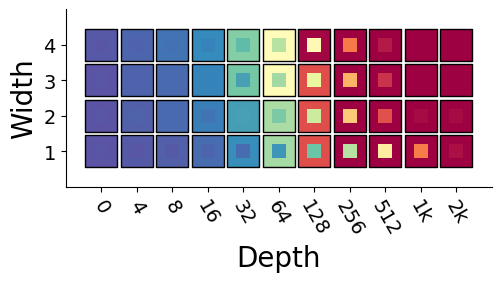

In [15]:
# Creates the plot like those in Fig. 2a of arXiv:2008.11294. The inner squares
# are the randomized mirror circuits, and the outer squares are the periodic
# mirror circuits.
from matplotlib import cm as _cm
spectral = _cm.get_cmap('Spectral')
fig, ax = pygsti.report.volumetric_plot(vb_min['PMC'], scale=1.9, cmap=spectral, figsize=(5.5,8))
fig, ax = pygsti.report.volumetric_plot(vb_min['RMC'], scale=0.4, cmap=spectral, fig=fig, ax=ax, linescale=0.)

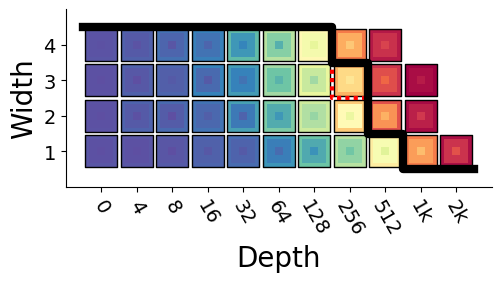

In [16]:
# Creates a plot like those in Fig. 1d of arXiv:2008.11294. But note
# that these RMCs don't have the same sampling as those in Fig. 1d:
# this is just the same type of plot from RMC data, not the same
# type of RMCs. To get the same color map as in Fig. 1d, set cmap=None
vbdf1 = vbdf.select_column_value('CircuitType', 'RMC')
fig, ax = pygsti.report.volumetric_distribution_plot(vbdf1, figsize=(5.5,8), cmap=spectral)

In [ ]:
# Randomized mirror circuit data can also be used for "RB", i.e., estimating an average
# gate error rate by fitting data to an exponential. Below shows how to do this, and
# shows the RB error rates versus the number of qubits.
rb = pygsti.protocols.RB(datatype='adjusted_success_probabilities', defaultfit='A-fixed')

In [ ]:
rb_results = {}
r = {}
for key, subdata in data.items():
    if 'RMCs' in key:
        rb_results[key] = rb.run(subdata)
        n_qubits = int(key.split('-')[0])
        r[n_qubits] = rb_results[key].fits['A-fixed'].estimates['r']

In [ ]:
from matplotlib import pyplot as plt
plt.plot(widths, [r[w] for w in widths], 'o')
plt.xlabel('Number of Qubits')
plt.ylabel("RB Error Rate")
plt.show()